In [17]:
import numpy as np
import math
import soundfile as sf
import matplotlib.pyplot as plt
import sys
import os
path = "/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/06/BladeRunner.wav"

In [18]:
# This is a helping funvtion that contains different types of kernels
def kappa(x, y, kernel_type, kernel_params):
  value = None
  if kernel_type == 'gaus':
    sigma = kernel_params[0]
    N = len(x)
    norm = sum((x-y)**2)
    value = np.exp(-norm/(sigma**2))
  elif kernel_type == 'gaus_c':
    sigma = kernel_params[0]
    N = len(x)
    exponent = sum( (x-y.conj())**2 )
    # value = 2*(math.exp( -np.real(exponent)/(sigma**2) ))
    value = 2*np.real(np.exp(-exponent/(sigma**2)))
  elif kernel_type == 'linear':
    value = 0
    N = len(x)
    for i in range(0, N):
      value = value + x[i]*y[i].conj()
  elif kernel_type == 'poly':
    d = kernel_params[0]
    value = (1 + x*y.transpose())**d
    # value = ( (1 + x*y.transpose())/( math.sqrt(np.real(x*x.transpose())* np.real(y*y.transpose()) ) ) )**d;
  elif kernel_type == 'poly_c':
    d = kernel_params[0]
    value = 2*np.real((1 + x*y.transpose())**d)
  # value = 2*np.real( ( (1 + x*y.transpose())/( math.sqrt(np.real(x*x.transpose()) * np.real(y*y.transpose()) ) ) )**d )
  return value

In [19]:
def kernel_regression_l2_l2_unbiased(X, y, params, kernel_type, kernel_params):
  lmbda = params[0]
  # build kernel matrix
  [d, N] = X.shape
  # for n=1:N
  #   for m=1:N
  #     K(n,m) = kappa(X(:,n), X(:,m), kernel_type, kernel_params);
  #   end;
  # end;
  if kernel_type == 'gaus':
    par = kernel_params
    norms = np.zeros(shape=(N, N))
    for i in range(0, N):
      T = X - X[:, i] # bsxfun(@minus,X,X(:,i))
      norms[i, :] = np.sum(T**2, axis=0)
    K = np.exp(-norms/(par**2))
  elif kernel_type == 'gaus_c':
    par = kernel_params
    norms = np.zeros(shape=(N, N))
    for i in range(0, N):
      T = X - X[:, i].conj() # bsxfun(@minus,X,conj(X(:,i)))
      norms[i, :] = np.sum(T**2, axis=0)
    K = 2*np.real(np.exp(-norms/(par**2)))
  else:
    K = np.zeros(shape=(N, N))
    for i in range(0, N):
      for j in range(0, N):
        K[i, j] = kappa(X[:, i], X[:, j], kernel_type, kernel_params)
  I = np.eye(N)
  A = lmbda*I+K
  c = y
  
  # Solve A*x=c
  sol = np.linalg.solve(A, c)
  return sol

In [20]:
# -----------------------------------------------------------------
# Kernel Ridge Regression
# on an audio sequence corrupted by
# Gaussian noise and outliers
# You need a .wav file to run the experiment...
# Python3 required packages: numpy, soundfile, matplotlib
# -----------------------------------------------------------------
def kernelridge_11_19():
  np.random.seed(0)
  # --------------------------------------------------------------------
  # Reading wav file. x corresponds to time instances (is., x_i in [0,1])
  # fs is the sampling frequency
  # Replace the name "BladeRunner.wav" with the name of the file
  # you intend to use.
  # --------------------------------------------------------------------
  N = 100
  samples = 1000
  indices = range(0, samples,int(samples/N))
  start = 100000
  [data, fs] = sf.read(path)
  sound = np.array(data[start:(start+samples+1), :], dtype=np.float32)
  y = np.reshape(sound[indices, 0], newshape=(len(indices), 1))
  Ts = 1/fs # sampling period
  x = np.array(range(0, samples)).conj().transpose()*Ts # time instances of sampling
  x = x[indices]
  x = np.reshape(x, newshape=(x.shape[0], 1))
  #print(x)
  # -------------------------------------------------------
  # Add white Gaussian noise
  snr = 15 # dB
  y = py_awgn(y, snr)
  # add outliers
  O = 0.8*np.max(np.abs(y))
  percent = 0.1
  M = int(math.floor(percent*N))
  out_ind = np.random.choice(N, M, replace=False)
  outs = np.sign(np.random.randn(M, 1))*O
  y[out_ind] = y[out_ind] + outs
  M = len(y)
  # ----------Code for unbiased L2 Kernel Ridge Regression (KRR-L2)-----------
  C = 0.01
  kernel_type = 'gaus'
  kernel_params = 0.05
  sol = kernel_regression_l2_l2_unbiased(x.conj().transpose(), y, [C], kernel_type, kernel_params)
  a0 = sol[0:N]
  # Generate regressor
  t = np.array([range(0, samples)]).conj().transpose()*Ts # Here we generate all 1000 points that will be used for prediction
  #t = np.array([range(0, samples+1)]).conj().transpose()*Ts
  M2 = len(t)
  print(M2)
  z0 = np.zeros(shape=(M2, 1))
  for k in range(0, M2):
    z0[k] = 0
    for l in range(0, N):
      z0[k] = z0[k] + a0[l]*kappa(x[l], t[k], kernel_type,[kernel_params])
  # ------------------end unbiased KRR-L2-------------------------------------
  # For unbiased KRR-L2
  plt.figure(1)
  # plot(x,y);
  plt.xlabel('time in sec')
  plt.ylabel('amplitude')
  plt.plot(t, z0, 'r', lw=1)
  plt.plot(x, y, '.', markeredgecolor=[0.3, 0.3, 0.3], markersize=5)
  title = 'unbiased KRR-L2 C= %s' % str(C)
  plt.title(title)
  plt.show()


1000


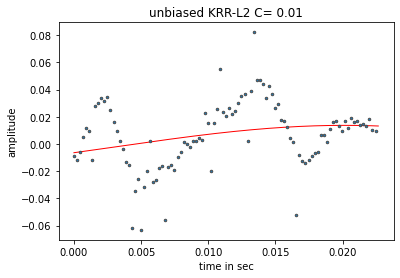

In [21]:
def py_awgn(input_signal, snr_dB, rate=1.0):
  """ Addditive White Gaussian Noise (AWGN) Channel.
  Parameters
  __________
  input_signal : 1D ndarray of floats
  Input signal to the channel.
  snr_dB : float
  Output SNR required in dB.
  rate : float
  Rate of the a FEC code used if any, otherwise 1.
  Returns
  _______
  output_signal : 1D ndarray of floats
  Output signal from the channel with the specified SNR.
  """
  avg_energy = np.sum(np.dot(input_signal.conj().T, input_signal)) / input_signal.shape[0]
  snr_linear = 10 ** (snr_dB / 10.0)
  noise_variance = avg_energy / (2 * rate * snr_linear)
  if input_signal.dtype is np.complex:
    noise = np.array([np.sqrt(noise_variance) * np.random.randn(input_signal.shape[0]) * (1 + 1j)], ndmin=2)
  else:
    noise = np.array([np.sqrt(2 * noise_variance) * np.random.randn(input_signal.shape[0])], ndmin=2)
  output_signal = input_signal + noise.conj().T
  return output_signal

if __name__ == '__main__':
  kernelridge_11_19()